In [1]:
import numpy as np
import sklearn.metrics
import tensorflow as tf
from tensorflow import keras
import os
import glob
import skimage.io as io
import skimage
import pdb
from tensorflow.contrib import eager as tfe
from util import load_pascal
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import pdb
from tensorflow.contrib import eager as tfe
tf.enable_eager_execution()

In [2]:
CLASS_NAMES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
               'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
               'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
test_npz = 'test.npz'
with np.load(test_npz) as test_npzfile:
    test_images = test_npzfile['imgs']
    test_labels = test_npzfile['labels']
    test_weights = test_npzfile['weights']

In [ ]:
idx =10
print(test_labels[idx])
print(test_weights[idx])
plt.imshow(test_images[idx])


In [3]:

class SimpleCNN(keras.Model):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__(name='CaffeNet')
        self.num_classes = num_classes
        self.conv1 = layers.Conv2D(filters=96,
                                   kernel_size=[11, 11],
                                   padding="valid",
                                   strides=4,
                                   activation='relu')
        self.pool1 = layers.MaxPool2D(pool_size=(3, 3),strides=2)
        self.conv2 = layers.Conv2D(filters=256,
                                   kernel_size=[5, 5],
                                   padding="same",
                                   activation='relu')
        self.pool2 = layers.MaxPool2D(pool_size=(3, 3),strides=2)
        self.conv3 = layers.Conv2D(filters=384,
                                   kernel_size=[3, 3],
                                   padding="same",
                                   activation='relu')

        self.conv4 = layers.Conv2D(filters=384,
                                   kernel_size=[3, 3],
                                   padding="same",
                                   activation='relu')
        self.conv5 = layers.Conv2D(filters=256,
                                   kernel_size=[3, 3],
                                   padding="same",
                                   activation='relu')
        self.pool3 = layers.MaxPool2D(pool_size=(3, 3), strides=2)
        self.flat = layers.Flatten()

        self.dense1 = layers.Dense(4096, activation='relu')
        self.dropout = layers.Dropout(rate=0.5)
        self.dense2 = layers.Dense(4096, activation='relu')
        self.dropout2 = layers.Dropout(rate=0.5)
        self.dense3 = layers.Dense(num_classes)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool3(x)
        flat_x = self.flat(x)
        out = self.dense1(flat_x)
        out = self.dropout(out, training=training)
        out = self.dense2(out)
        out = self.dropout2(out, training=training)
        out = self.dense3(out)
        return out
    
    def fc7 (self,inputs,training=False):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool3(x)
        flat_x = self.flat(x)
        out = self.dense1(flat_x)
        out = self.dropout(out, training=training)
        out = self.dense2(out)
        return out
    
    def pool5 (self,inputs,training=False):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool3(x)
        flat_x = self.flat(x)

        return flat_x

    def compute_output_shape(self, input_shape):
        shape = tf.TensorShape(input_shape).as_list()
        shape = [shape[0], self.num_classes]
        return tf.TensorShape(shape)

In [4]:
test_images = test_images[:1000]
test_labels = test_labels[:1000]
test_weights = test_weights[:1000]

rgb_mean = np.array([123.68, 116.78, 103.94],dtype=np.float32) / 256.0
test_images = (test_images - rgb_mean).astype(np.float32)

def center_crop (img,lbl,wts):
    # image = tf.image.central_crop(img,[224,224,3])
    image = tf.image.resize_image_with_crop_or_pad(
                                    img,
                                    224,
                                    224)
    return image, lbl, wts
ccrop_fn = lambda img,lbl,wts : center_crop(img,lbl,wts)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels, test_weights))
test_dataset = test_dataset.map(ccrop_fn,num_parallel_calls=4)
test_dataset = test_dataset.batch(20)

In [5]:
model = SimpleCNN(num_classes=len(CLASS_NAMES))
optimizer = tf.train.MomentumOptimizer(learning_rate=0.001, momentum=0.9)
checkpoint_directory = "./03_pascal_caffenet/"
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
status = checkpoint.restore('./03_pascal_caffenet/ckpt-62')
for batch, (images, labels,weights) in enumerate(test_dataset):
    dummy = model(images)
    break



conv1 = model.layers[0].get_weights()   

In [21]:
feat_list =[]
lab_list = []
pool_list =[]


for (images, labels, weights) in tfe.Iterator(test_dataset):
#     feats = model.fc7(images,training=False)
#     feat_list.append(feats.numpy().reshape(-1,4096))
    pool_list.append(model.pool5(images,training=False))
    lab_list.append(labels.numpy().reshape(-1,20))


# features = np.concatenate(feat_list, axis=0)
features = np.concatenate(pool_list, axis=0)
gt_labels = np.concatenate(lab_list,axis=0)

In [23]:

pool_list[0].shape
features.shape

(1000, 6400)

In [ ]:
c = np.random.rand(20,3)
c_list =[]
for (_,labels,_) in tfe.Iterator(test_dataset):
#     lab_list.append(labels.numpy().reshape(-1,20))
    lbls = labels.numpy()
    for l in lbls:
        num  = np.sum(l)
        cl = np.sum(l.reshape(20,1)*c,axis=0).reshape(1,3)/num
        c_list.append(cl)
        
cls = np.concatenate(c_list,axis=0)
cls.shape
# gt_labels = np.concatenate(lab_list,axis=0)
                   
        

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(features)

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.scatter(tsne[:,0],tsne[:,1],c=cls)
# plt.legend()
plt.savefig('tsne_caffenet.png')

In [ ]:
# import seaborn as sns
# sns.set_style('darkgrid')
# sns.set_palette('muted')
# sns.set_context("notebook", font_scale=1.5,
#                 rc={"lines.linewidth": 2.5})

# def scatter(x, labels):
#     # We choose a color palette with seaborn.
#     palette = np.array(sns.color_palette("hls", (20)))
#     colors = np.zeros(len(labels))
#     for i in range(len(labels)):
#         label = labels[i]
#         print(label)

#         index = (label > 0)

#         c = 0
#         count = 0
#         for j in range(len(label)):
#             if label[j] > 0:
#                 c += j
#                 count+=1
#         if count >0:
#             c = c/count
#         colors[i] = c
#     # We create a scatter plot.
#     f = plt.figure(figsize=(8, 8))
#     ax = plt.subplot(aspect='equal')

#     sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,c=colors )
#     plt.xlim(-25, 25)
#     plt.ylim(-25, 25)
#     ax.axis('off')
#     ax.axis('tight')
    
# #     import pdb; pdb.set_trace()
    
#     sns.palplot(palette)


#     # We add the labels for each digit.
#     return f, ax, sc
# # --------------------------------------------------------------------------
# def plotTSNE(features, labels):
#     tsne = TSNE(n_components=2)
#     tsneResults = tsne.fit_transform(features)
#     scatter(tsneResults, labels)
#     plt.savefig('tsne_CaffeNetfc7.png', dpi=120)

In [ ]:
# plotTSNE(features,gt_labels)

In [ ]:
cls.shape

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]
height = [1]*20
bars = CLASS_NAMES
y_pos = np.arange(len(bars))*2
plt.bar(y_pos, height, color=c,align='edge', width=0.5)

plt.xticks(y_pos, bars)
plt.savefig('tsne_legend.png')



In [ ]:
import util
test_AP, test_mAP = util.eval_dataset_map(model, test_dataset)

In [ ]:
print("Caffenet results: \n")
print('Obtained {} mAP'.format(test_mAP))
for cid, cname in enumerate(CLASS_NAMES):
    print('{}: {}'.format(cname, util.get_el(test_AP, cid)))

In [ ]:
features.shape
np.min(test_images[0,:,:,:])

In [ ]:
plt.close()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.show()
plt.xticks([])
plt.yticks([])
for i in range(10):
    plt.figure()
    plt.imshow(test_images[i,:,:,:])

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
tfs = np.zeros([10,4096])
for i in range(10):
    plt.figure()
    plt.imshow(test_images[i,:,:,:])
    tfs[i] = model(test_images[i,:,:,:].reshape(1,256,256,3))

In [24]:
from sklearn.neighbors import NearestNeighbors
tfs = features[:10]
nbrs = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(features)
dists, inds = nbrs.kneighbors(tfs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

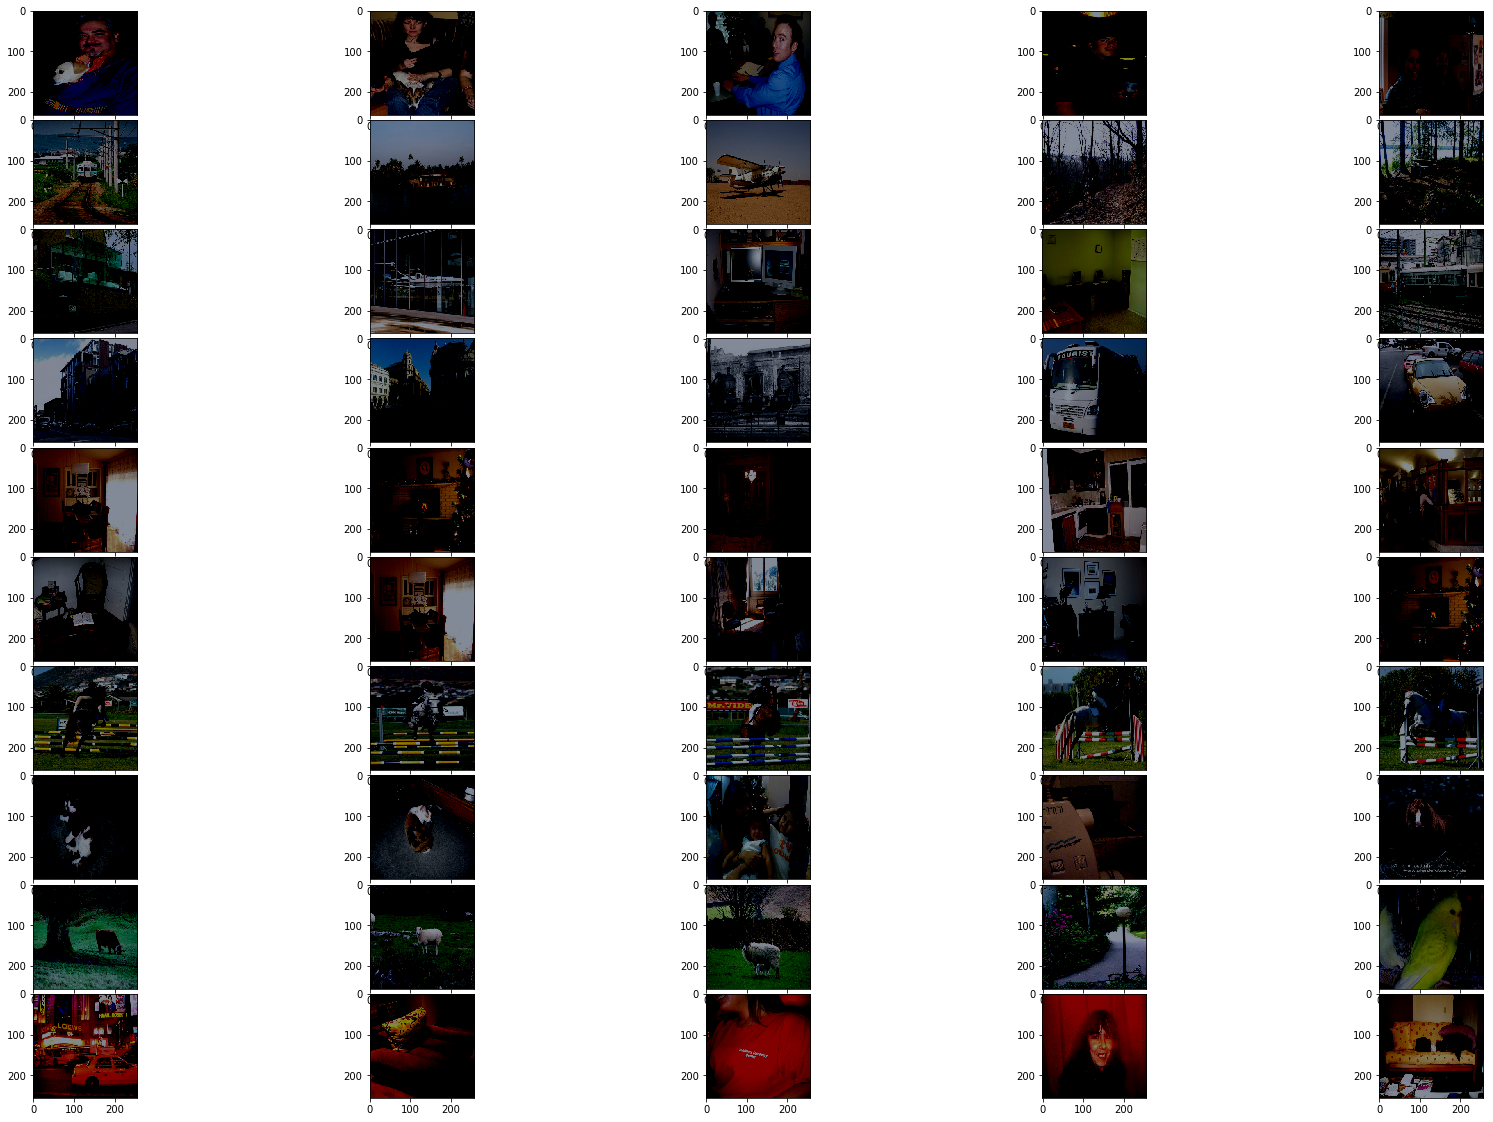

In [25]:
plt.rcParams['figure.figsize'] = [20, 10]
import matplotlib.gridspec as gridspec
# f, axarr = plt.subplots(10,5,sharex=True, sharey=True)
fig=plt.figure(figsize=(30, 20))
gs1 = gridspec.GridSpec(10, 5)
gs1.update(wspace=0.025, hspace=0.05)
cnt = 1
for i in range(10):
    for j in range(5):
        fig.add_subplot(gs1[cnt-1])
        plt.imshow(test_images[inds[i,j],:,:,:])
        cnt+=1
        
#         pyplot.subplot(test_images[inds[i,j],:,:,:])
#         axarr[i,j].imshow(test_images[inds[i,j],:,:,:])